In [1]:
#This cell is based on the work of Ayan Paul et al
import numpy as np                              
import pandas as pd                             
import sklearn.model_selection as ms            
import matplotlib.pyplot as plt                 
import sys
import os
import ast
import urllib.request as req                    
census_key = "6565205267ce8e6b218d4f8f6cf3b2eb3003f572"
population_density_url = 'https://api.census.gov/data/2019/pep/population?get=DENSITY&in=state:*&for=county:*&key={}'.format(census_key)
above_65_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S0101_C02_030E&in=state:*&for=county:*&key={}'.format(census_key)
transport_url = 'https://api.census.gov/data/2018/acs/acs5?get=GEO_ID,NAME,B08006_001E,B08006_003E,B08006_017E&in=state:*&for=county:*&key={}'.format(census_key)
race_url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=GEO_ID,NAME,DP05_0070E,DP05_0077E&in=state:*&for=county:*&key={}'.format(census_key)
poverty_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S1701_C03_001E&in=state:*&for=county:*&key={}'.format(census_key)
income_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S1902_C03_019E&in=state:*&for=county:*&key={}'.format(census_key)
employed_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S2301_C03_001E&in=state:*&for=county:*&key={}'.format(census_key)
unemployment_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S2301_C04_001E&in=state:*&for=county:*&key={}'.format(census_key)
mean_commute_url = 'https://api.census.gov/data/2018/acs/acs5/subject?get=GEO_ID,NAME,S0801_C01_046E&in=state:*&for=county:*&key={}'.format(census_key)
labour_url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=GEO_ID,NAME,DP03_0028PE,DP03_0030PE,DP03_0031PE&in=state:*&for=county:*&key={}'.format(census_key)
insurance_url = 'https://api.census.gov/data/2018/acs/acs5/profile?get=GEO_ID,NAME,DP03_0099PE&in=state:*&for=county:*&key={}'.format(census_key)
jhu_deaths = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
jhu_confirmed = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'

In [2]:
#This cell is based on the work of Ayan Paul et al
def get_census_data(url):
    df = pd.DataFrame(ast.literal_eval(req.urlopen(req.Request(url)).read().decode('utf8').replace('null', '"1"')))
    df.columns = df.iloc[0]
    df = df[1:]
    df['FIPS'] = df.pop('GEO_ID').apply(lambda x: int(x[-5:]))
    return df

In [3]:
#This cell is based on the work of Ayan Paul et al
density = pd.DataFrame(ast.literal_eval(req.urlopen(req.Request(population_density_url)).read().decode('utf8').replace('null', '"0"')))
density.columns = density.iloc[0]
density = density[1:]
density.DENSITY = density.DENSITY.astype('float32')
density.state = density.state.astype('string')
density.county = density.county.astype('string')
density['FIPS'] = density['state'] + density['county']
density.FIPS = density.FIPS.astype('int32')
density = density.drop(labels=['state', 'county'], axis=1)
columns = density.columns.tolist()
columns = columns[::-1]
density = density[columns]
density.drop(density[density['DENSITY'] == 0].index , inplace=True)
density.DENSITY = np.log10(density.DENSITY)
density.rename(columns={'DENSITY': 'Density'}, inplace=True)

In [4]:
deaths = pd.read_csv(jhu_deaths)
deaths.drop(deaths[(deaths['FIPS'] < 1000) | (deaths['FIPS'] > 57000)].index , inplace=True)
deaths.dropna(inplace=True)
confirmed = pd.read_csv(jhu_confirmed)
confirmed.drop(confirmed[(confirmed['FIPS'] < 1000) | (confirmed['FIPS'] > 57000)].index , inplace=True)
confirmed.dropna(inplace=True)
deaths_df = deaths[['FIPS', '10/20/21']]
confirmed_df = confirmed[['FIPS', '10/20/21']]
fatality_rate = deaths_df
fatality_rate['rate'] = (deaths_df['10/20/21'] / confirmed_df['10/20/21'] )
q1 = fatality_rate.quantile(.25)
q2 = fatality_rate.quantile(.5)
q3 = fatality_rate.quantile(.75)
print(q1)
print(q2)
print(q3)

FIPS        18174.500000
10/20/21       26.000000
rate            0.011957
Name: 0.25, dtype: float64
FIPS        29174.000000
10/20/21       64.000000
rate            0.016207
Name: 0.5, dtype: float64
FIPS        45079.500000
10/20/21      157.000000
rate            0.021858
Name: 0.75, dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
conditions = [
    (fatality_rate['rate'] <= 0.011957),
    (fatality_rate['rate'] > 0.011957) & (fatality_rate['rate'] <= 0.016207),
    (fatality_rate['rate'] > 0.016207) & (fatality_rate['rate'] <= 0.021858),
    (fatality_rate['rate'] > 0.021858)
    ]

values = [1,2,3,4]
fatality_rate['rate_q'] = np.select(conditions, values)

In [6]:
#This cell is based on the work of Ayan Paul et al
# The FIPS and state names
df_census = get_census_data(above_65_url)
df_census = df_census[['FIPS', 'NAME']]
df_census['State'] = df_census.pop('NAME').str.split(', ').str[1]
df_census = df_census.sort_values(df_census.columns[0], ignore_index=True)
df_census = pd.merge(df_census, density, on='FIPS')

# 2018 5 year ACS data on Age
dft = get_census_data(above_65_url)
dft = dft[['FIPS', 'S0101_C02_030E']]
dft.rename(columns={'S0101_C02_030E': 'Senior Citizen'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Senior Citizen'] = df_census['Senior Citizen'].apply(lambda x: float(x))/100.

# 2018 5 year ACS data on transport used
dft = get_census_data(transport_url)
dft['Transit-1'] = 1. - (dft['B08006_003E'].astype('float')+dft['B08006_017E'].astype('float'))/dft['B08006_001E'].astype('float')
dft = dft[['FIPS', 'Transit-1']]
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Transit'] = df_census.pop('Transit-1')
df_census.at[df_census[df_census['FIPS']==35039].index, 'Transit'] = 0.159 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on non-white
dft = get_census_data(race_url)
# dft['Non-White'] = 1. - dft['B02001_002E'].astype('float')/dft['B02001_001E'].astype('float')
dft['Non-White'] = 1. - dft['DP05_0077E'].astype('float')/dft['DP05_0070E'].astype('float')
dft = dft[['FIPS', 'Non-White']]
df_census = pd.merge(df_census, dft, on='FIPS')

# 2018 5 year ACS data on Poverty
dft = get_census_data(poverty_url)
dft = dft[['FIPS', 'S1701_C03_001E']]
dft.rename(columns={'S1701_C03_001E': 'Poverty-1'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Poverty'] = df_census.pop('Poverty-1').apply(lambda x: float(x))/100.
df_census.at[df_census[df_census['FIPS']==35039].index, 'Poverty'] = 0.237 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Income per capita
dft = get_census_data(income_url)
dft = dft[['FIPS', 'S1902_C03_019E']]
dft.rename(columns={'S1902_C03_019E': 'Income/Capita'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Income/Capita'] = df_census['Income/Capita'].apply(lambda x: float(x))
df_census.at[df_census[df_census['FIPS']==35039].index, 'Income/Capita'] = 19678 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Employment
dft = get_census_data(employed_url)
dft = dft[['FIPS', 'S2301_C03_001E']]
dft.rename(columns={'S2301_C03_001E': 'Employed-1'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Employed'] = df_census.pop('Employed-1').apply(lambda x: float(x))/100.
df_census.at[df_census[df_census['FIPS']==35039].index, 'Employed'] = 0.382287 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Unemployment
dft = get_census_data(unemployment_url)
dft = dft[['FIPS', 'S2301_C04_001E']]
dft.rename(columns={'S2301_C04_001E': 'Unemployment-1'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Unemployment'] = df_census.pop('Unemployment-1').apply(lambda x: float(x))/100.
df_census.at[df_census[df_census['FIPS']==35039].index, 'Unemployment'] = 0.114 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Mean Commute in minutes
dft = get_census_data(mean_commute_url)
dft = dft[['FIPS', 'S0801_C01_046E']]
dft.rename(columns={'S0801_C01_046E': 'MeanCommute'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['MeanCommute'] = df_census['MeanCommute'].apply(lambda x: float(x))
df_census.at[df_census[df_census['FIPS']==35039].index, 'MeanCommute'] = 26.2 ## Imputed value from 2011 since values are null in 2018
df_census.at[df_census[df_census['FIPS']==48301].index, 'MeanCommute'] = 25.4 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Labour
dft = get_census_data(labour_url)
dft['Labour'] = (dft['DP03_0028PE'].astype('float') + dft['DP03_0030PE'].astype('float') + dft['DP03_0031PE'].astype('float'))/100.
dft = dft[['FIPS', 'Labour']]
df_census = pd.merge(df_census, dft, on='FIPS')
df_census.at[df_census[df_census['FIPS']==35039].index, 'Labour'] = 0.271 + 0.108 + 0.07 ## Imputed value from 2011 since values are null in 2018

# 2018 5 year ACS data on Health Insurance
dft = get_census_data(insurance_url)
dft = dft[['FIPS', 'DP03_0099PE']]
dft.rename(columns={'DP03_0099PE': 'Uninsured'}, inplace=True)
df_census = pd.merge(df_census, dft, on='FIPS')
df_census['Uninsured'] = df_census.pop('Uninsured').apply(lambda x: float(x))/100.

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [7]:
# Collecting all the necessary features into one dataframe
df_census_curated = pd.DataFrame()
df_census_curated['FIPS'] = df_census['FIPS']
df_census_curated['State'] = df_census['State']
df_census_curated['Density'] = df_census['Density']
df_census_curated['Non-White'] = df_census['Non-White']
df_census_curated['Poverty'] = df_census['Poverty']
df_census_curated['Income'] = df_census['Income/Capita']
df_census_curated['Unemployment'] = df_census['Unemployment']
df_census_curated['Uninsured'] = df_census['Uninsured']
df_census_curated['Employed'] = df_census['Employed']
df_census_curated['Labor'] = df_census['Labour']
df_census_curated['Transit'] = df_census['Transit']
df_census_curated['Mean Commute'] = df_census['MeanCommute']
df_census_curated['Senior Citizen'] = df_census['Senior Citizen']

In [9]:
df_census_curated_new = df_census_curated.merge(fatality_rate, on='FIPS')

In [10]:
df_state = df_census_curated_new.loc[df_census_curated_new['State'] == "California"]
#California Texas Florida New York pennsylvania 

In [11]:
df_census_curated_new_dropped = df_census_curated_new.drop(columns=['FIPS', 'State'])

In [12]:
df_state = df_state.drop(columns=['FIPS', 'State'])

In [13]:
y_state = df_state['rate_q'].values

In [14]:
y = df_census_curated_new_dropped['rate_q'].values

In [15]:
df_x = df_census_curated_new_dropped.drop(columns=['rate_q','rate','10/20/21'])

In [16]:
df_x_state = df_state.drop(columns=['rate_q','rate','10/20/21'])

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_x_state, y_state, test_size=0.3) 

In [18]:
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=10, max_features = None)
print(clf.fit(X_train,y_train).score(X_train, y_train))

0.925


In [19]:
from sklearn.inspection import permutation_importance
importance = permutation_importance(clf,df_x_state,y_state,scoring='recall_weighted',n_repeats=100,n_jobs=-1,random_state=0)

In [ ]:
sorted_idx = importance.importances_mean.argsort()[::-1]
sorted_idx = sorted_idx[0:101]
arr1 = df_x_state.columns[sorted_idx]
list1 = arr1.tolist()
print(list1)
arr2 = importance.importances_mean[sorted_idx]
list2 = arr2.tolist()
print(list2)
list3 = sorted_idx.tolist()
print(list3)

In [21]:
Cali_var = ['Mean Commute', 'Income', 'Density', 'Unemployment', 'Transit', 'Senior Citizen', 'Non-White', 'Labor', 'Poverty', 'Employed', 'Uninsured']
Cali_val = [0.09362068965517242, 0.06775862068965519, 0.06500000000000002, 0.04120689655172417, 0.03172413793103452, 0.02293103448275865, 0.015344827586206927, 0.009482758620689678, 0.006034482758620734, 0.0, 0.0]
Tex_var = ['Labor', 'Poverty', 'Employed', 'Density', 'Senior Citizen', 'Non-White', 'Transit', 'Unemployment', 'Mean Commute', 'Uninsured', 'Income']
Tex_val = [0.09625984251968506, 0.0916929133858268, 0.09082677165354332, 0.06590551181102361, 0.03795275590551184, 0.035511811023622074, 0.03346456692913389, 0.024724409448818898, 0.02043307086614172, 0.014566929133858255, 0.008385826771653528]
Florida_var = ['Senior Citizen', 'Mean Commute', 'Density', 'Transit', 'Poverty', 'Uninsured', 'Employed', 'Non-White', 'Labor', 'Unemployment', 'Income']
Florida_val = [0.16298507462686562, 0.03955223880597009, 0.036865671641790984, 0.023432835820895476, 0.02119402985074622, 0.0025373134328357826, -0.002388059701492572, -0.004179104477611972, -0.004477611940298546, -0.008059701492537336, -0.016865671641791095]
NY_var = ['Senior Citizen', 'Uninsured', 'Non-White', 'Density', 'Unemployment', 'Labor', 'Employed', 'Mean Commute', 'Income', 'Poverty', 'Transit']
NY_val = [0.14274193548387093, 0.07290322580645157, 0.06322580645161287, 0.03532258064516126, 0.030967741935483843, 0.027741935483870942, 0.005483870967741931, 0.005483870967741928, 0.002741935483870962, 0.00032258064516129005, -0.009354838709677417]
Penn_var = ['Income', 'Senior Citizen', 'Poverty', 'Mean Commute', 'Employed', 'Density', 'Unemployment', 'Transit', 'Labor', 'Uninsured', 'Non-White']
Penn_val = [0.22044776119402978, 0.1667164179104477, 0.1016417910447761, 0.06492537313432833, 0.03701492537313431, 0.014328358208955186, 0.012985074626865609, 0.010895522388059669, 0.01044776119402981, 0.00820895522388056, 0.0035820895522387765]

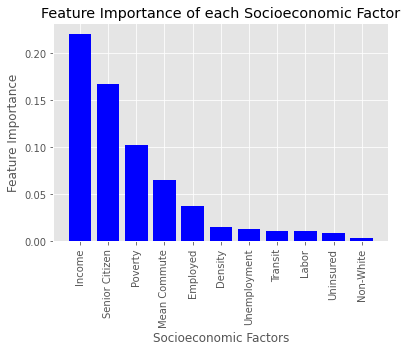

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
x_pos = [i for i, _ in enumerate(Penn_var)]
plt.bar(x_pos, Penn_val, color='blue')
plt.xlabel("Socioeconomic Factors")
plt.ylabel("Feature Importance")
plt.title("Feature Importance of each Socioeconomic Factor")
plt.xticks(x_pos, Penn_var,rotation = 90)
plt.show()